# Graph filtering
Suggest new ingredients to add to a recipe by applying different filters to the graph and choosing the new ingredient with the highest weight after filtering.
We implemented the follwing filters:
* Ideal bandpass
* Graph shift (see Sandryhaila et al.)
* Minimizing graph total variance (see Sandryhaila et al.)

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
from graphProcessingFunctions import *

In [3]:
adj_mat = np.load('../data/Adjacency_Matrix_3.npy') #Recipe feature CORA-style adjacency matrix
ingredient_list = np.load('../data/Ingredient_List.npy')

In [5]:
with open('../data/recipes_with_nutritional_info_fixed_qty.json') as json_file:
    data = json.load(json_file)
df = pd.DataFrame(data)

In [6]:
def createIngredientSignal(df,recipe_number,ingredient_list):
    """Generate a boolean signal from a recipe with 1's in the positions of the ingredients it contains and zeros elsewhere.
    Use the full ingredient name"""
    entry = df.iloc[recipe_number]
    recipe = entry['ingredients']
    ingredients = []
    for ingredient in recipe:
        ingredients += [ingredient['text']]
    indices = np.in1d(ingredient_list,ingredients)
    output = np.zeros(ingredient_list.shape)
    output[indices] = 1;
    return output

In [7]:
def createIngredientSignalFirstWord(df,recipe_number,ingredient_list):
    """Generate a boolean signal from a recipe with 1's in the positions of the ingredients it contains and zeros elsewhere.
    Use only the first word of the ingredient"""
    entry = df.iloc[recipe_number]
    recipe = entry['ingredients']
    ingredients = []
    for ingredient in recipe:
        ingredients += [ingredient['text'].split(',')[0]]
    indices = np.in1d(ingredient_list,ingredients)
    output = np.zeros(ingredient_list.shape)
    output[indices] = 1;
    return output

In [9]:
laplacian = compute_laplacian(adj_mat, normalize=True)
lam, U = spectral_decomposition(laplacian)

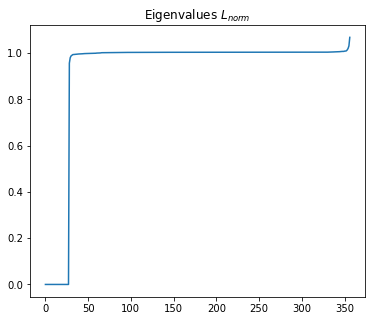

In [10]:
plt.figure(figsize=(6, 5))
plt.plot(lam)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [21]:
def GFT(signal, U):
    return U.T @ signal

def iGFT(fourier_coefficients, U):
    return U @ fourier_coefficients

## Plot the spectrum of a recipe signal
We can see that most signals have a few low frequency components, and then a lot of activity around the eigenvalue 1

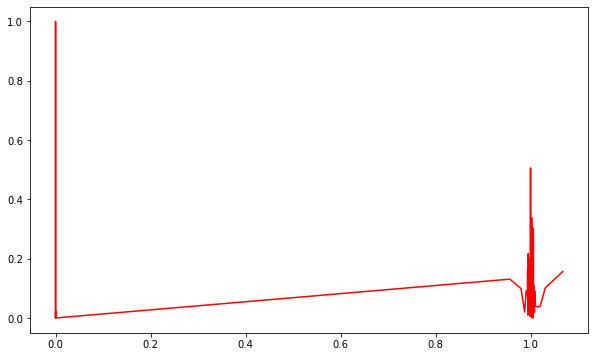

In [27]:
ingr_signal = createIngredientSignal(df,1,ingredient_list)
plt.figure(figsize=(10, 6))
plt.plot(lam, np.abs(GFT(ingr_signal,U)), 'r-') 

In [23]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray, U):
    """Return a filtered signal."""
    x_gft = GFT(x,U)
    filter_gft = x_gft * spectral_response
    return iGFT(filter_gft,U)

In [28]:
def predictNewIngredient(df, test_recipe, ingredient_list, adj_mat):
    '''Suggest a new ingredient using graph filtering with an ideal bandpass filter.
    Ideally, the new ingredient should be the one that does not already exist in the recipe but has the highest weight after filtering
    '''
    ingr_signal = createIngredientSignal(df,test_recipe,ingredient_list)
    laplacian = compute_laplacian(adj_mat, normalize=True)
    lam, U = spectral_decomposition(laplacian)
    ideal_bp = np.ones(lam.shape)
    ideal_bp[lam >= 1] = 0 
    ideal_bp[lam <= 0.8] = 0 
    x_bp = ideal_graph_filter(ingr_signal,ideal_bp,U)
    x_bp[ingr_signal > 0] = 0;
    new_ingr_ndx = np.argmax(x_bp)
    new_ingredient = ingredient_list[new_ingr_ndx]
    recipe_name = df.iloc[test_recipe]['title']
    original_ingredients = ingredient_list[ingr_signal > 0]
    return new_ingredient, recipe_name, original_ingredients

In [35]:
def predictNewIngredient_graphShift(df, test_recipe, ingredient_list, adj_mat):
    """Suggest a new ingredient by applying the graph shift filter described in the Carnegie Mellon paper"""
    ingr_signal = createIngredientSignal(df,test_recipe,ingredient_list)
    x_filtered = adj_mat @ ingr_signal
    x_filtered[ingr_signal > 0] = 0;
    new_ingr_ndx = np.argmax(x_filtered)
    new_ingredient = ingredient_list[new_ingr_ndx]
    recipe_name = df.iloc[test_recipe]['title']
    original_ingredients = ingredient_list[ingr_signal > 0]
    return new_ingredient, recipe_name, original_ingredients

In [32]:
def predictNewIngredient_graphTotalVariance(df, test_recipe, ingredient_list, adj_mat):
    """Suggest a new ingredient by finding which ingredient addition minimizes the graph total variance, 
    as described by the Carnegie Mellon paper"""
    ingr_signal = createIngredientSignal(df,test_recipe,ingredient_list)
    gtvs = np.ones([len(ingr_signal),1])*10000
    lap = compute_laplacian(adj_mat, True)
    for i in range(len(ingr_signal)):
        new_ingr_signal = np.reshape(ingr_signal,(len(ingr_signal),1))
        if ingr_signal[i] == 0:
            new_ingr_signal[i] = 1
            gtv = new_ingr_signal.T @ lap @ new_ingr_signal
            gtvs[i] = gtv
            ingr_signal[i] = 0
    new_ingr_ndx = np.argmin(gtvs)
    new_ingredient = ingredient_list[new_ingr_ndx]
    recipe_name = df.iloc[test_recipe]['title']
    original_ingredients = ingredient_list[ingr_signal > 0]
    return new_ingredient, recipe_name, original_ingredients

## Prediction using graph shift
Since this implementation is a simple matrix multiplication by the adjacency matrix, it is prone to 

In [36]:
test_recipes = [14, 8, 19, 39, 60, 73]
for tr in test_recipes:
    print("Recipe name: {1}\nOriginal Ingredients: {2}\nSuggested Ingredient: {0}\n".format(*predictNewIngredient_graphShift(df, tr, ingredient_list, adj_mat)))

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: peppers, ancho, dried

Recipe name: Chocolate-Orange Angel Food Cake
Original Ingredients: ['cocoa, dry powder, unsweetened' 'egg, white, raw, fresh'
 'orange juice, raw' 'salt, table' 'sugars, granulated' 'sugars, powdered'
 'wheat flour, white, cake, enriched']
Suggested Ingredient: peppers, ancho, dried

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: peppers, ancho, dried

Recipe name: Creamy Curry Salad Dressing
Original Ingredients: ['honey' 'lemon juice, raw' 'salad dress

## Suggestion by minimizing graph total variance
Since this implementation minimizes the variation on the graph, it tends to suggest the same "obvious" ingredients

In [33]:
test_recipes = [14, 8, 19, 39, 60, 73]
for tr in test_recipes:
    print("Recipe name: {1}\nOriginal Ingredients: {2}\nSuggested Ingredient: {0}\n".format(*predictNewIngredient_graphTotalVariance(df, tr, ingredient_list, adj_mat)))

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: butter, without salt

Recipe name: Chocolate-Orange Angel Food Cake
Original Ingredients: ['cocoa, dry powder, unsweetened' 'egg, white, raw, fresh'
 'orange juice, raw' 'salt, table' 'sugars, granulated' 'sugars, powdered'
 'wheat flour, white, cake, enriched']
Suggested Ingredient: butter, without salt

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: butter, without salt

Recipe name: Creamy Curry Salad Dressing
Original Ingredients: ['honey' 'lemon juice, raw' 'salad dressing

## Suggestion using ideal bandpass filter
We want the filter to predict something non-obvious (ex. salt, pepper, olive oil), but not something completely unpalatable. Therefore, we apply a bandpass filter with cutoffs of 0.8 and 1.1 eigenvalues. The results are fairly promising!

In [31]:
test_recipes = [14, 8, 19, 39, 60, 73]
for tr in test_recipes:
    print("Recipe name: {1}\nOriginal Ingredients: {2}\nSuggested Ingredient: {0}\n".format(*predictNewIngredient(df, tr, ingredient_list, adj_mat)))

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: onions, spring or scallions (includes tops and bulb), raw

Recipe name: Chocolate-Orange Angel Food Cake
Original Ingredients: ['cocoa, dry powder, unsweetened' 'egg, white, raw, fresh'
 'orange juice, raw' 'salt, table' 'sugars, granulated' 'sugars, powdered'
 'wheat flour, white, cake, enriched']
Suggested Ingredient: candies, semisweet chocolate

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: goji berries, dried

Recipe name: Creamy Curry Salad Dressing
Original Ingredients: